In [ ]:
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental.ode import odeint
from jax import config

import matplotlib.pyplot as plt

In [ ]:
u_fn = lambda x, t : np.cos(t)
s_exact_fn = lambda x : np.sin(x)

In [ ]:
m = 100  # number of input sensors
x = np.linspace(0, 1, m)

P = 100  # number of output sensors
y = np.linspace(0, 1, P)

In [ ]:
u = vmap(u_fn, (None, 0))(0.0, x)
s_exact = s_exact_fn(y)

s = odeint(u_fn, 0.0, y)

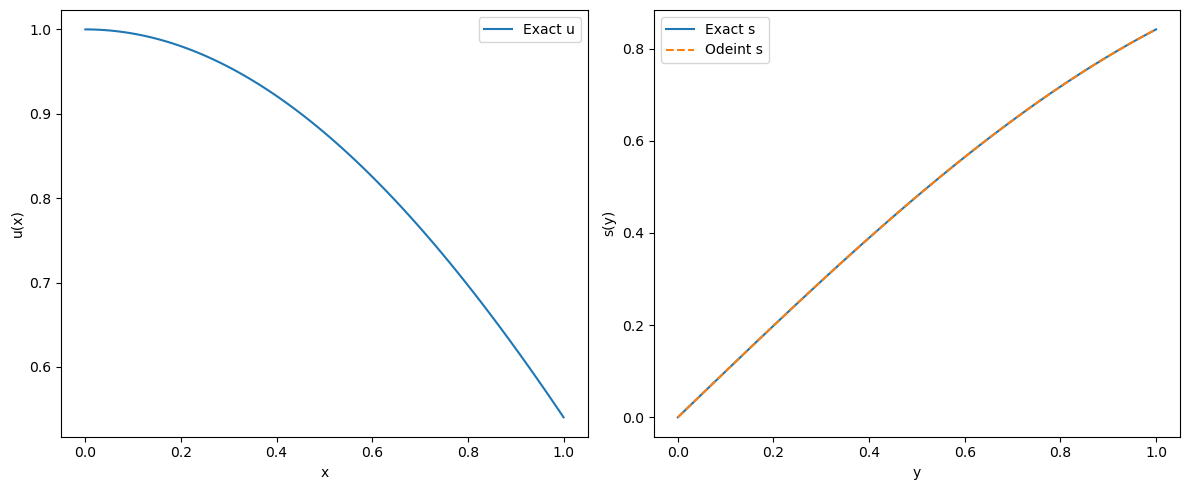

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, u, label='Exact u')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y, s_exact, label='Exact s')
plt.plot(y, s, '--', label='Odeint s')
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Length scale of a Gaussian random field (GRF)
length_scale = 0.2

# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=100, P=1):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = np.tile(u, (P, 1))

    # training data for the residual
    u_r_train = np.tile(u, (m, 1))
    y_r_train = x
    s_r_train = u

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = np.tile(u, (P,1))

    return u, y, s 

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m, P))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * m,-1))
    y_r_train = np.float32(y_r_train.reshape(N * m,-1))
    s_r_train = np.float32(s_r_train.reshape(N * m,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
    s = np.float32(s.reshape(N * P,-1))

    config.update("jax_enable_x64", False)
    return u, y, s


In [ ]:
# Training data for  operator loss
N_train = 5
m = 3 # number of input sensors
P_train = 2   # number of output sensors
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train)

In [ ]:
u_train

Array([[ 0.5416952 , -1.2182713 ,  0.02805518],
       [ 0.5416952 , -1.2182713 ,  0.02805518],
       [ 0.2561699 ,  1.7361244 , -0.12842911],
       [ 0.2561699 ,  1.7361244 , -0.12842911],
       [ 0.31091952,  0.21510072, -0.69573903],
       [ 0.31091952,  0.21510072, -0.69573903],
       [-1.1744708 , -0.2615771 , -0.24291062],
       [-1.1744708 , -0.2615771 , -0.24291062],
       [ 0.87082636, -0.8753194 ,  1.3036394 ],
       [ 0.87082636, -0.8753194 ,  1.3036394 ]], dtype=float32)

In [ ]:
y_train

Array([[0.50940776],
       [0.5325489 ],
       [0.06969871],
       [0.17341422],
       [0.11679448],
       [0.7406584 ],
       [0.630989  ],
       [0.7420011 ],
       [0.12419782],
       [0.3782477 ]], dtype=float32)

In [ ]:
s_train

Array([[ 0.45332184],
       [ 0.4225012 ],
       [ 0.0153981 ],
       [ 0.03151167],
       [ 0.05650196],
       [ 0.15932417],
       [-0.31372786],
       [-0.26649174],
       [ 0.06639019],
       [-0.01799228]], dtype=float32)

In [ ]:
u_r_train

Array([[ 0.5416952 , -1.2182713 ,  0.02805518],
       [ 0.5416952 , -1.2182713 ,  0.02805518],
       [ 0.5416952 , -1.2182713 ,  0.02805518],
       [ 0.2561699 ,  1.7361244 , -0.12842911],
       [ 0.2561699 ,  1.7361244 , -0.12842911],
       [ 0.2561699 ,  1.7361244 , -0.12842911],
       [ 0.31091952,  0.21510072, -0.69573903],
       [ 0.31091952,  0.21510072, -0.69573903],
       [ 0.31091952,  0.21510072, -0.69573903],
       [-1.1744708 , -0.2615771 , -0.24291062],
       [-1.1744708 , -0.2615771 , -0.24291062],
       [-1.1744708 , -0.2615771 , -0.24291062],
       [ 0.87082636, -0.8753194 ,  1.3036394 ],
       [ 0.87082636, -0.8753194 ,  1.3036394 ],
       [ 0.87082636, -0.8753194 ,  1.3036394 ]], dtype=float32)

In [ ]:
y_r_train

Array([[0. ],
       [0.5],
       [1. ],
       [0. ],
       [0.5],
       [1. ],
       [0. ],
       [0.5],
       [1. ],
       [0. ],
       [0.5],
       [1. ],
       [0. ],
       [0.5],
       [1. ]], dtype=float32)

In [ ]:
s_r_train

Array([[ 0.5416952 ],
       [-1.2182713 ],
       [ 0.02805518],
       [ 0.2561699 ],
       [ 1.7361244 ],
       [-0.12842911],
       [ 0.31091952],
       [ 0.21510072],
       [-0.69573903],
       [-1.1744708 ],
       [-0.2615771 ],
       [-0.24291062],
       [ 0.87082636],
       [-0.8753194 ],
       [ 1.3036394 ]], dtype=float32)

In [ ]:
# Training data for  operator loss
N_train = 10000
m = 100 # number of input sensors
P_train = 100   # number of output sensors
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train)

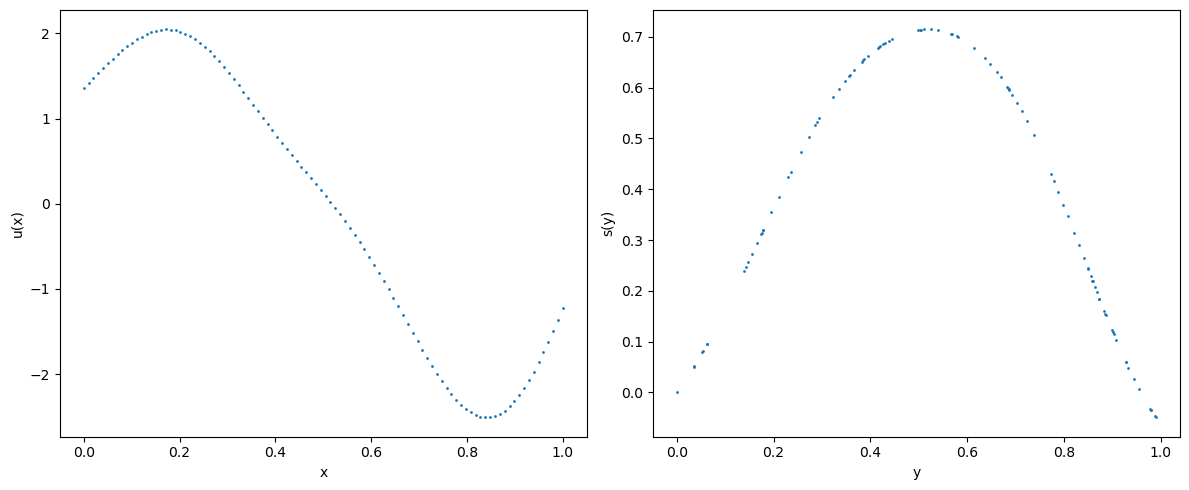

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0, 1, m), u_train[0, :], 'o', markersize=1)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.tight_layout()

plt.subplot(1,2,2)
plt.scatter(y_train[:P_train], s_train[:P_train], s=1)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.show()